# Fake News Capstone Project Data Wrangling and Preprocessing

In [1]:
import s3fs
import pandas as pd
pd.set_option('display.max_columns', 100000)
pd.set_option('display.max_row', 1000000)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import tldextract
from tqdm.autonotebook import tqdm
tqdm.pandas(desc="progress-bar", leave=False)
import string
import spacy
from spacy.lang import punctuation
import unicodedata  # might need to pip install unicodedate2 on aws sagemaker
from contractions import CONTRACTION_DICT # need to have the contractions.py file copied to your path
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import STOPWORDS
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style='darkgrid',palette='Dark2',rc={'figure.figsize':(9,6),'figure.dpi':90})

punctuation = string.punctuation + '”' + '“' + '–' + '““' + "’’" + '”'
stopword = stopwords.words('english')
stopwords = set(STOPWORDS)
wordnet_lemmatizer = WordNetLemmatizer()

<ipython-input-1-e3f470490460>:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:701: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Random seed

In [2]:
seed = 123

## Read in the dataset

In [3]:
df = pd.read_csv('s3://osanusi-auto/capstone_prep2021.csv')
df.head(5)

,domain,type,content,title,authors
0,nytimes.com,real,FIRST PERSON\n\nAn Astonishingly Frank Self-Po...,The K.G.B. Candidate,Bernard Gwertzman
1,nytimes.com,real,"Under prodding from a federal judge, the Bush ...",White House Sets Deadline on Forest Rules,Douglas Jehl
2,nytimes.com,real,"Twenty-five years ago Aerosmith, the headliner...","Aerosmith, Relishing The Third Incarnation",Ann Powers
3,nytimes.com,real,"""The worst-case scenario for newly minted coll...","College Graduates for a Year, Hoping for Chanc...",Marc B. Zawel
4,nytimes.com,real,"Each night, the family members pitch their din...",Rolled by Hands Large and Small,Elaine Louie


In [4]:
# checking missing values
def missing_value(df):
    """" Function to calculate the number and percent of missing values in a dataframe"""
    total = df.isnull().sum().sort_values(ascending=False)
    percent = ((df.isnull().sum()/df.isnull().count())*100).sort_values(ascending=False)
    missing_value = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
    return missing_value

In [5]:
missing_value(df)

,Total,Percent
authors,0,0.0
title,0,0.0
content,0,0.0
type,0,0.0
domain,0,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1090432 entries, 0 to 1090431
Data columns (total 5 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   domain   1090432 non-null  object
 1   type     1090432 non-null  object
 2   content  1090432 non-null  object
 3   title    1090432 non-null  object
 4   authors  1090432 non-null  object
dtypes: object(5)
memory usage: 41.6+ MB


## Clean up the domain and check the unique domains

In [7]:
def extract_domain(url):
    """
    Extract domain name from fld url
    """
    info = tldextract.extract(url)
    return info.domain

In [8]:
df['domain'] = df['domain'].astype(str).apply(extract_domain)
df.head(3)

,domain,type,content,title,authors
0,nytimes,real,FIRST PERSON\n\nAn Astonishingly Frank Self-Po...,The K.G.B. Candidate,Bernard Gwertzman
1,nytimes,real,"Under prodding from a federal judge, the Bush ...",White House Sets Deadline on Forest Rules,Douglas Jehl
2,nytimes,real,"Twenty-five years ago Aerosmith, the headliner...","Aerosmith, Relishing The Third Incarnation",Ann Powers


## Cleaning up the content column by removing all the noises

In [9]:
def remove_special_characters(text): 
    """
    Removes special characters from the text document
    """
    # define the pattern to keep. You can check the regex using this url https://regexr.com/
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]'
    return re.sub(pat, '', text)

def remove_extra_whitespace_tabs(text): 
    """
    Removes extra whitespaces and remove_extra_whitespace_tabs
    """
    #pattern = r'^\s+$|\s+$'
    pattern = r'^\s*|\s\s*'
    return re.sub(pattern, ' ', text).strip()

def remove_digits(text): 
    """
    Remove all digits from the text document
     take string input and return a clean text without numbers.
        Use regex to discard the numbers.
    """
    result = ''.join(i for i in text if not i.isdigit()).lower()
    return ' '.join(result.split())

def remove_newlines(text): 
    """
    Remove newline characters from the text document
    """
    return text.replace('\\n', ' ').replace('\\r', ' ').replace('\n', ' ').replace('\r', ' ').replace('\\', ' ')

#normalize to the NFKD (Normalization Form Compatibility Decomposition) form
#that present in the Unicode standard to remain compatible with other encodings
def remove_accented_chars(text): 
    """
    Removes accented characters from the test
    """
    new_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return new_text

#expands contractions found in the text
def expand_contractions(text, contraction_mapping=CONTRACTION_DICT):

    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

# replace punctuation characters with spaces
def replace_punctuation(text):
    filters = string.punctuation + '”' + '“' + '–' 
    translate_dict = dict((c, " ") for c in filters)   
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    return text

# Remove stopwords and remove words with 2 or less characters
def stops_letters(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stopword:
            result.append(token)
            
    return " ".join(result)

#Removes any word that starts with either http or https
def remove_urls (vTEXT):
    #vTEXT = re.sub('http://\S+|https://\S+', '', vTEXT,flags=re.MULTILINE)
    vTEXT = re.sub('http[s]?://\S+', '', vTEXT,flags=re.MULTILINE)
    return(vTEXT)
#Remove words that starts with www
def remove_www (vTEXT):
    vTEXT = re.sub('www\S+', '', vTEXT,flags=re.MULTILINE)
    return(vTEXT)


In [10]:
%%time
# Apply the functions to the dataframe

# Step 1 - convert the text to lower case
df['content']=df['content'].apply(lambda x: x.lower())
df['title']=df['title'].apply(lambda x: x.lower())
df['authors']=df['authors'].apply(lambda x: x.lower())

#step 2 - Remove URLS
df['content']=df['content'].apply(remove_urls)
df['title'] = df['title'].apply(remove_urls)

#step 3 - Remove www
df['content']=df['content'].apply(remove_www)
df['title'] = df['title'].apply(remove_www)

# Step 4 - remove special charcaters
df['content']=df['content'].apply(remove_special_characters)
df['title'] = df['title'].apply(remove_special_characters)

#step 5 - Remove whitespaces and tabs
df['content']=df['content'].apply(remove_extra_whitespace_tabs)
df['title'] = df['title'].apply(remove_extra_whitespace_tabs)
df['authors'] = df['authors'].apply(remove_extra_whitespace_tabs)

#step 6 - remove newlines and tabs
df['content'] = df['content'].apply(remove_newlines)
df['title'] = df['title'].apply(remove_newlines)

# step 7 - Remove digits
df['content']=df['content'].apply(remove_digits)
df['title'] = df['title'].apply(remove_digits)

#step 8 - remove accented characters
df['content']=df['content'].apply(remove_accented_chars)
df['title'] = df['title'].apply(remove_accented_chars)

#step 9 - Expand contractions
df['content']=df['content'].apply(expand_contractions)

#step 10 - Replace punctuations with spaces 
df['content']= df['content'].apply(replace_punctuation)
df['title'] = df['title'].apply(replace_punctuation)
df['authors'] = df['authors'].apply(replace_punctuation)

#step 11 - Remove stopwords, tokenize and remove words with 2 or less characters
df['content']= df['content'].apply(stops_letters)
df['title'] = df['title'].apply(stops_letters)
df['authors'] = df['authors'].apply(stops_letters)


Wall time: 3h 6min 58s


## Normalization - Lemmatize the title and content columns

In [11]:
def lemmatized_word(text):
    """
    lemmatize the text so as to get its root form 
    """
    word_tokens = nltk.word_tokenize(text)
    lemmatized_word = [wordnet_lemmatizer.lemmatize(word) for word in word_tokens]
    return  " ".join(lemmatized_word) #combine the words into a giant string that vectorizer can accept


In [12]:
df['content'] = df['content'].progress_apply(lemmatized_word)
df['title'] = df['title'].progress_apply(lemmatized_word)


progress-bar:   0%|          | 0/1090432 [00:00<?, ?it/s]

progress-bar:   0%|          | 0/1090432 [00:00<?, ?it/s]

## Quick look at the authors column

In [13]:
df.groupby('type')['authors'].nunique().reset_index()

,type,authors
0,fake,9005
1,real,59204


<AxesSubplot:>

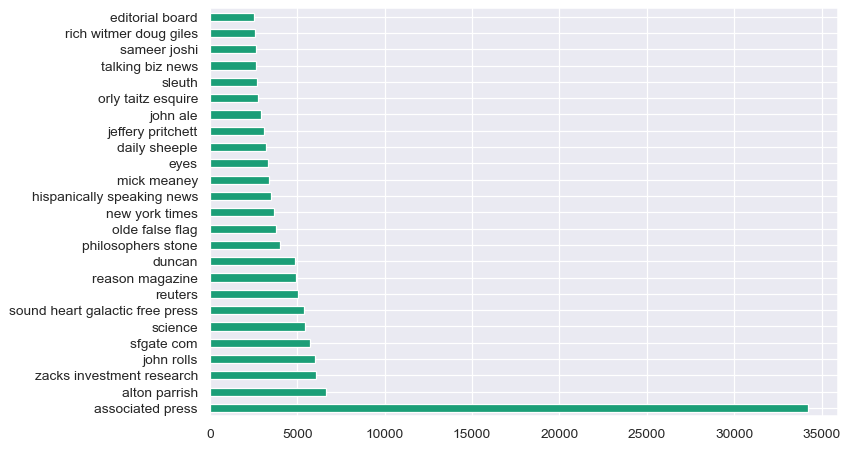

In [14]:
df.authors.value_counts(ascending=False).head(25).plot.barh()

## Create additional features

In [15]:
%%time
# word counts
df['c_word_count'] = df["content"].apply(lambda x: len(str(x).split(" ")))
df['t_word_count'] = df["title"].apply(lambda x: len(str(x).split(" ")))

# Character counts
df['c_character_count'] = df["content"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
df['t_character_count'] = df["title"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))

#average word length
df['c_avg_word_length'] = df['c_character_count'] / df['c_word_count']
df['t_avg_word_length'] = df['t_character_count'] / df['t_word_count']


Wall time: 1min 20s


## Identify sentiment in the title

In [16]:
def sentiment_check (text):
    polarity_score = TextBlob(text).sentiment.polarity
    if polarity_score < 0:
        return 'negative'
    elif polarity_score == 0:
        return 'neutral'
    else:
        return 'positive'

In [17]:
%%time
df['sentiment'] = df['title'].apply(sentiment_check)
df.head(3)

Wall time: 5min 29s


,domain,type,content,title,authors,c_word_count,t_word_count,c_character_count,t_character_count,c_avg_word_length,t_avg_word_length,sentiment
0,nytimes,real,person astonishingly frank selfportrait russia...,candidate,bernard gwertzman,423,1,2696,9,6.373522,9.000000,neutral
1,nytimes,real,prodding federal judge bush administration sai...,white house set deadline forest rule,douglas jehl,125,6,834,31,6.672000,5.166667,neutral
2,nytimes,real,twentyfive year ago aerosmith headliner saturd...,aerosmith relishing incarnation,ann powers,188,3,1208,29,6.425532,9.666667,neutral


## Rename the target column

In [18]:
df = df.rename({'type': 'label'}, axis=1)  


## Rearranged the order of the columns

In [19]:
df = df[['domain','title','authors','content','c_word_count','t_word_count','c_character_count','t_character_count','c_avg_word_length','t_avg_word_length','sentiment','label']]
df.head(3)

,domain,title,authors,content,c_word_count,t_word_count,c_character_count,t_character_count,c_avg_word_length,t_avg_word_length,sentiment,label
0,nytimes,candidate,bernard gwertzman,person astonishingly frank selfportrait russia...,423,1,2696,9,6.373522,9.000000,neutral,real
1,nytimes,white house set deadline forest rule,douglas jehl,prodding federal judge bush administration sai...,125,6,834,31,6.672000,5.166667,neutral,real
2,nytimes,aerosmith relishing incarnation,ann powers,twentyfive year ago aerosmith headliner saturd...,188,3,1208,29,6.425532,9.666667,neutral,real


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1090432 entries, 0 to 1090431
Data columns (total 12 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   domain             1090432 non-null  object 
 1   title              1090432 non-null  object 
 2   authors            1090432 non-null  object 
 3   content            1090432 non-null  object 
 4   c_word_count       1090432 non-null  int64  
 5   t_word_count       1090432 non-null  int64  
 6   c_character_count  1090432 non-null  int64  
 7   t_character_count  1090432 non-null  int64  
 8   c_avg_word_length  1090432 non-null  float64
 9   t_avg_word_length  1090432 non-null  float64
 10  sentiment          1090432 non-null  object 
 11  label              1090432 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 99.8+ MB


In [21]:
df.head(4)

,domain,title,authors,content,c_word_count,t_word_count,c_character_count,t_character_count,c_avg_word_length,t_avg_word_length,sentiment,label
0,nytimes,candidate,bernard gwertzman,person astonishingly frank selfportrait russia...,423,1,2696,9,6.373522,9.000000,neutral,real
1,nytimes,white house set deadline forest rule,douglas jehl,prodding federal judge bush administration sai...,125,6,834,31,6.672000,5.166667,neutral,real
2,nytimes,aerosmith relishing incarnation,ann powers,twentyfive year ago aerosmith headliner saturd...,188,3,1208,29,6.425532,9.666667,neutral,real
3,nytimes,college graduate year hoping chance throe reality,marc zawel,worstcase scenario newly minted college grad s...,288,7,1847,43,6.413194,6.142857,neutral,real


## Saving the preprocessed dataframe to csv

In [22]:
# path to save the preprocessed csv file
file_path = r"C:\Users\lanre\Documents\data_science\capstone-preprocessed-data.csv"

In [23]:
df.to_csv(file_path, index=False)